<a href="https://colab.research.google.com/github/WesleyHung/comp3359-Emotion-Analysis/blob/master/project_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comp3359 Project
# Emotion Analysis AI machine


Listed some styles of our machine here...
*   Text classification
*   Supervised learning
*   LSTM (Type of RNN)
*   Attention Mechanism (encoding/ decoding)



# Load the data

In [118]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify directory of course materials in Google Drive
module_dir = '/content/drive/My Drive/'

# Path to data file
data_path = os.path.join(module_dir, 'text_emotion.csv')      #I put my dataset in my google drive, you can do so by copying from the sharing file

#Loading the dataset into pandas DataFrame
data_df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


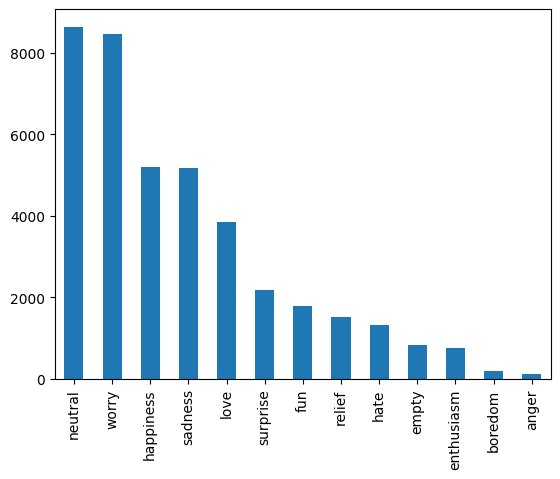

In [119]:
# Plot label histogram
data_df.sentiment.value_counts().plot.bar()

In [120]:
data_df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


Taking the only useful features

In [122]:
data_df = data_df[['sentiment', 'content']]
data_df

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


# Separate Training/Test Dataset

## Global variable

In [0]:
# Random seed for all random process we will use.
RAND_SEED = 3359
# Size of training dataset (the rest, i.e., 20%,  will be test data)
TRAIN_SIZE = 0.8

## Seperate dataset

In [0]:
all_idx = list(range(len(data_df)))

# Shuffle the list of indices
import random
random.seed(RAND_SEED)
random.shuffle(all_idx)

# Split the random indices into two portion according 
# to the training size defined
p = int(len(data_df) * TRAIN_SIZE)
train_idx = all_idx[:p]
test_idx = all_idx[p:]

# Now, retrieve training/test data records from data_df 
# according to the indices we prepared in train_idx and test_idx
train_df = data_df.iloc[train_idx]
test_df = data_df.iloc[test_idx]

# However, since the original indices from data_df will be attached to 
# the retrieved records in train_df and test_df,
# we need to reset index so indices in train_df/test_df will start from 0 as usual
train_df = train_df.reset_index()
test_df = test_df.reset_index()

# Drop the automatically created "index" column
train_df = train_df.drop(['index'], axis=1)
test_df = test_df.drop(['index'], axis=1)

In [125]:
train_df.head()

,sentiment,content
0,enthusiasm,@LeslieCraig haha maybe someday I will be your...
1,happiness,Skipping school like all the cool kids do
2,worry,missing cat makes me sad
3,neutral,"@lisamh77 Concord &amp; Irvine, CA only. That'..."
4,love,"@steph1985 Bye Btw, you like Simple Plan, Hoo..."


We want to further seperate a validation set for training

In [130]:
train_dev_size = 0.1
m = int(len(train_df) * train_dev_size)

train_set = train_df[m:]
val_set = train_df[:m]

print("Training Set: ", len(train_set))
print("Training-Dev Set: ", len(val_set))

train_set
val_set

Training Set:  28800
Training-Dev Set:  3200


,sentiment,content
0,enthusiasm,@LeslieCraig haha maybe someday I will be your...
1,happiness,Skipping school like all the cool kids do
2,worry,missing cat makes me sad
3,neutral,"@lisamh77 Concord &amp; Irvine, CA only. That'..."
4,love,"@steph1985 Bye Btw, you like Simple Plan, Hoo..."
...,...,...
3195,neutral,@buchmamsell ist im der Haus... or something l...
3196,relief,@TimJackson LOL I can imagine you doing that. ...
3197,neutral,@verwon Thanks for sharing it. Anything about ...
3198,sadness,went to the cd store to search for the cd. But


# Preprossesing the data

## Tokenization

In [131]:
input_sentences = [content.split(" ") for content in data_df["content"].values.tolist()]
labels = data_df["sentiment"].values.tolist()

input_sentences[0]

['@tiffanylue',
 'i',
 'know',
 '',
 'i',
 'was',
 'listenin',
 'to',
 'bad',
 'habit',
 'earlier',
 'and',
 'i',
 'started',
 'freakin',
 'at',
 'his',
 'part',
 '=[']

Remove redundant words.   ----> i.e. name start with "@" (I think this is uncessary)

In [0]:
"""
import re

prefix = '@'

for sentence in input_sentences:
  for word in sentence:
    if word.startswith(prefix):
        sentence.remove(word)

input_sentences[0]
"""

## Creating Vocabulary (word index)

In [0]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2word = {v: k for k, v in word2id.items()}
id2word

In [27]:
print(max_words)
print(id2word[2])

100



## Encoding samples with corresponing integer values

reference to the online material (can ignore it)

In [28]:

"""
import keras

# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))
"""

Using TensorFlow backend.


Shape of X: (40000, 100)
Shape of Y: (40000, 13)


In [0]:
sentence = X[0]
print(sentence)

for wordIndex in sentence:
    print(id2word[wordIndex])

reference from google

In [0]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = max_words

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [136]:
sequence_vectorize(train_set, val_set)

(array([[1],
        [2]], dtype=int32), array([[1],
        [2]], dtype=int32), {'content': 2, 'sentiment': 1})

# Build LSTM model with attention

In [30]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     6718000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 200)     160800      dropout_1[0][0]                  
____________________________________________________________________________________________

# Train the model

In [31]:
# Train model 10 iterations
model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 36000 samples, validate on 4000 samples
Epoch 1/2
36000/36000 [==============================] - 281s 8ms/step - loss: 2.0628 - accuracy: 0.2816 - val_loss: 1.9840 - val_accuracy: 0.3180
Epoch 2/2
36000/36000 [==============================] - 284s 8ms/step - loss: 1.7900 - accuracy: 0.3918 - val_loss: 1.9505 - val_accuracy: 0.3565


In [0]:
model.save("lstm_attention_v1_trained.h5")

# Testing and predicting

In [0]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

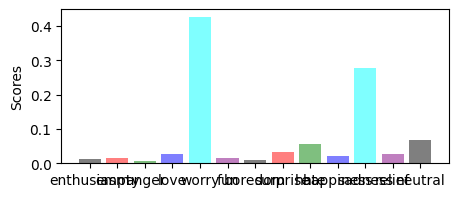

In [86]:
import random
import math

# Select random samples to illustrate
#sample_text = random.choice(dataset["content"].values.tolist())
sample_text = "no offence but this model is shit"


# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()


In [87]:
import operator

# create a list of emotion in decending order of their probability 
emotion_list=[]

for  _, emotion in enumerate(label_probs):
    temp = [emotion, label_probs[emotion]]
    emotion_list.append(temp)

sorted(emotion_list, key=operator.itemgetter(1), reverse= True)

[['worry', 0.42755288],
 ['sadness', 0.2779897],
 ['neutral', 0.067248635],
 ['hate', 0.056594618],
 ['surprise', 0.03338948],
 ['relief', 0.027693443],
 ['love', 0.02713557],
 ['happiness', 0.02033464],
 ['empty', 0.016740564],
 ['fun', 0.015996587],
 ['enthusiasm', 0.01341514],
 ['boredom', 0.0096796],
 ['anger', 0.0062292395]]